<a href="https://colab.research.google.com/github/Zardian18/EBM_cars_generation/blob/master/EBM_Cars_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-23 05:18:16--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0s      

2024-01-23 05:18:16 (70.5 MB/s) - ‘helper.py’ saved [17171/17171]



In [ ]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount("/content/drive")

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers, activations
from helper import sample_batch, display
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [5]:
! kaggle datasets download -d markminerov/88500-car-images

100% 2.91G/2.91G [02:59<00:00, 22.4MB/s]
100% 2.91G/2.91G [02:59<00:00, 17.3MB/s]


In [ ]:
! unzip 88500-car-images.zip

In [7]:
train_data = utils.image_dataset_from_directory(
    "/content/out",
    labels= None,
    color_mode= "rgb",
    image_size=(32,32),
    batch_size=128,
    shuffle = True,
    seed=42,
    interpolation= "bilinear"
)
train_data

Found 88560 files belonging to 1 classes.


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

In [8]:
def preprocess(imgs):
  imgs = (tf.cast(imgs, "float32")-127.5)/127.5
  return imgs

train = train_data.map(lambda x: preprocess(x))

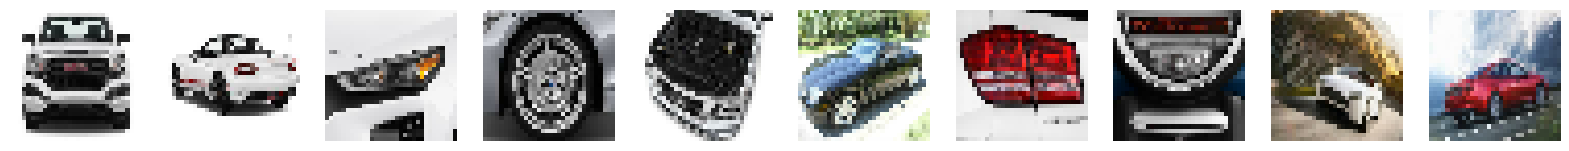

In [9]:
train_sample = sample_batch(train)
display(train_sample)

In [10]:
ebm_input = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    128, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328

In [11]:
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False
):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -0.03, 0.03)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

In [12]:
import random

class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, 32, 32, 3)) * 2
            - 1
            for _ in range(128)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(128, 0.05)
        rand_imgs = (
            tf.random.uniform((n_new, 32, 32, 3)) * 2 - 1
        )
        old_imgs = tf.concat(
            random.choices(self.examples, k=128 - n_new), axis=0
        )
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = tf.split(inp_imgs, 128, axis=0) + self.examples
        self.examples = self.examples[:8192]
        return inp_imgs

In [13]:
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = 0.1
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=0.005
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=60, step_size=10, noise=0.005
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            )
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            )
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, 32, 32, 3))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [14]:
ebm = EBM()

In [15]:
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001), run_eagerly=True
)

In [16]:
!mkdir output/

In [17]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, 32, 32, 3)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=10,
            noise=0.005,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to="./output/example_img_%03d.png" % (epoch)
        )


image_generator_callback = ImageGenerator(num_img=10)

In [18]:
!mkdir models/

In [19]:
class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("./models/model.h5")


save_model_callback = SaveModel()

Epoch 1/25


692/692 [==============================] - ETA: 0s - loss: -0.0019 - reg: 0.0119 - cdiv: -0.0138 - real: 0.0541 - fake: 0.0403
Saved to ./output/generated_img_000.png


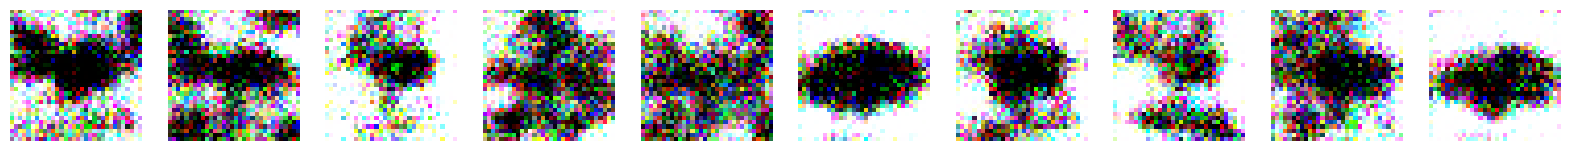


Saved to ./output/example_img_000.png


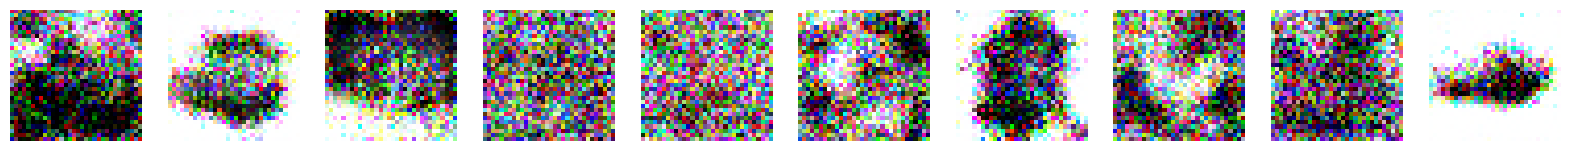

692/692 [==============================] - 899s 1s/step - loss: -0.0019 - reg: 0.0119 - cdiv: -0.0138 - real: 0.0541 - fake: 0.0403
Epoch 2/25
692/692 [==============================] - ETA: 0s - loss: 0.0013 - reg: 0.0025 - cdiv: -0.0013 - real: 0.0093 - fake: 0.0080
Saved to ./output/generated_img_001.png


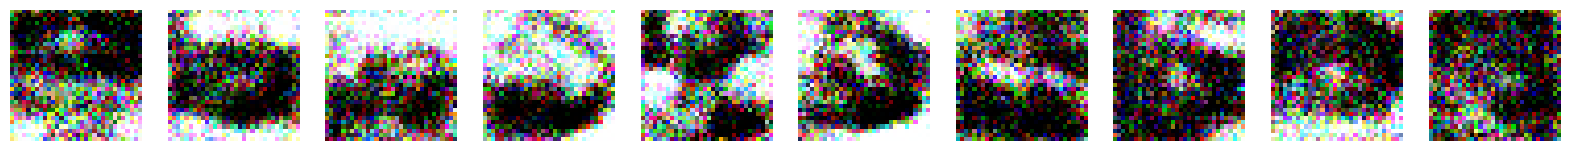


Saved to ./output/example_img_001.png


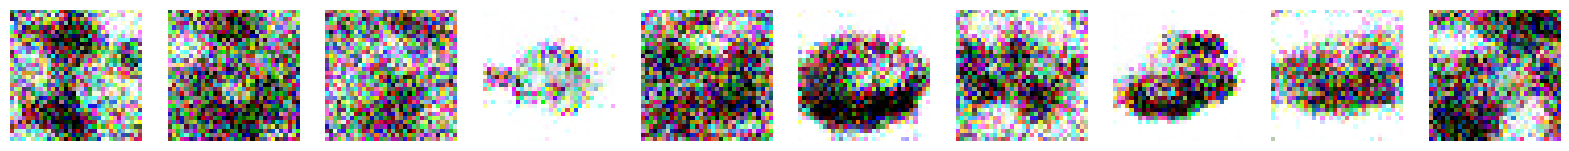

692/692 [==============================] - 890s 1s/step - loss: 0.0013 - reg: 0.0025 - cdiv: -0.0013 - real: 0.0093 - fake: 0.0080
Epoch 3/25
692/692 [==============================] - ETA: 0s - loss: 8.6597e-05 - reg: 0.0027 - cdiv: -0.0027 - real: 0.0032 - fake: 5.3698e-04
Saved to ./output/generated_img_002.png


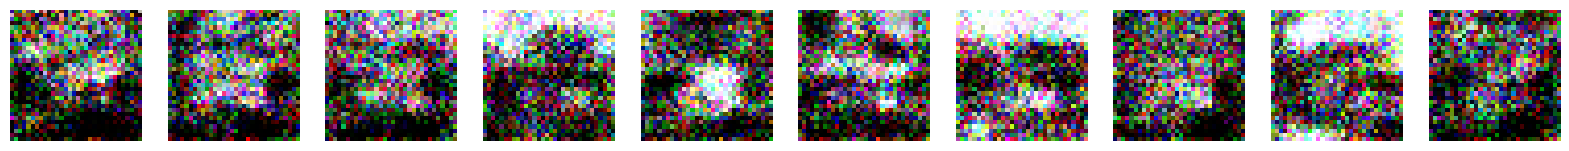


Saved to ./output/example_img_002.png


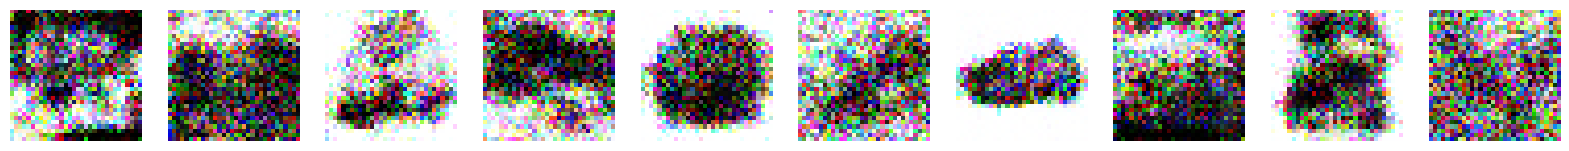

692/692 [==============================] - 920s 1s/step - loss: 8.6597e-05 - reg: 0.0027 - cdiv: -0.0027 - real: 0.0032 - fake: 5.3698e-04
Epoch 4/25
692/692 [==============================] - ETA: 0s - loss: -0.0013 - reg: 0.0041 - cdiv: -0.0054 - real: 0.0039 - fake: -0.0015
Saved to ./output/generated_img_003.png


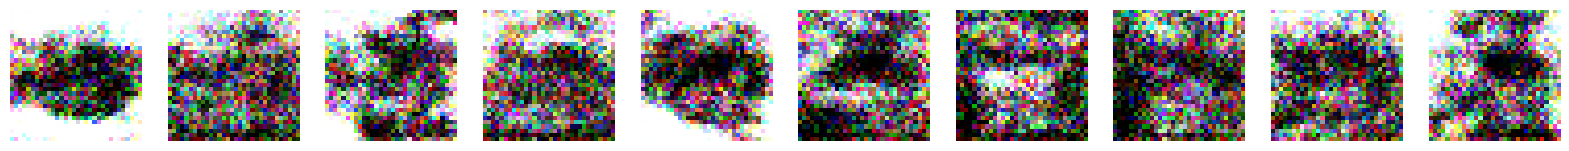


Saved to ./output/example_img_003.png


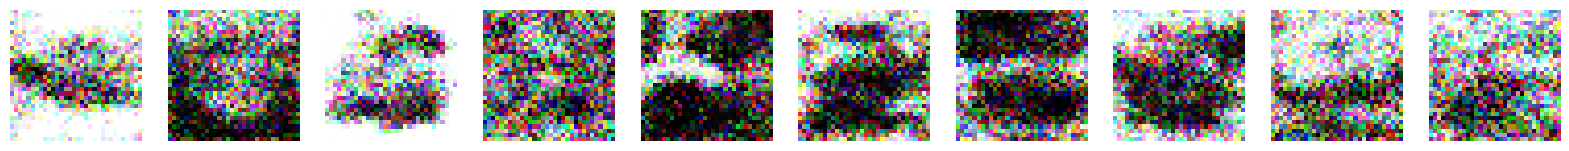

692/692 [==============================] - 899s 1s/step - loss: -0.0013 - reg: 0.0041 - cdiv: -0.0054 - real: 0.0039 - fake: -0.0015
Epoch 5/25
692/692 [==============================] - ETA: 0s - loss: -0.0011 - reg: 0.0035 - cdiv: -0.0046 - real: 0.0017 - fake: -0.0029
Saved to ./output/generated_img_004.png


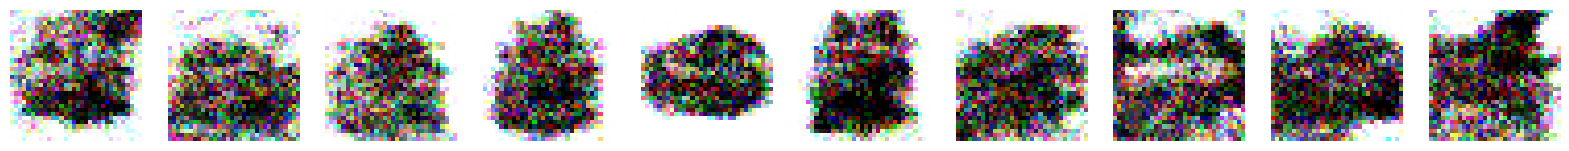


Saved to ./output/example_img_004.png


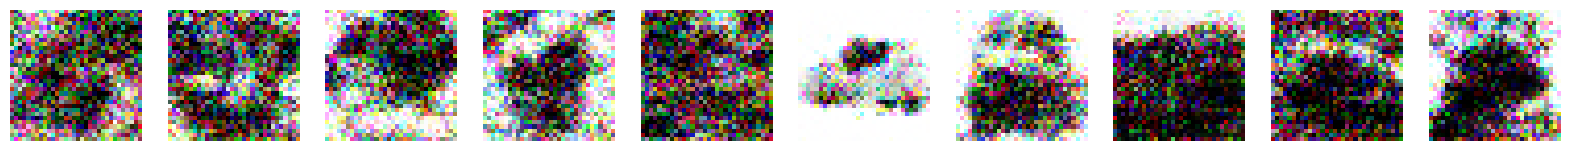

692/692 [==============================] - 898s 1s/step - loss: -0.0011 - reg: 0.0035 - cdiv: -0.0046 - real: 0.0017 - fake: -0.0029
Epoch 6/25
692/692 [==============================] - ETA: 0s - loss: -0.0028 - reg: 0.0046 - cdiv: -0.0074 - real: 0.0050 - fake: -0.0024
Saved to ./output/generated_img_005.png


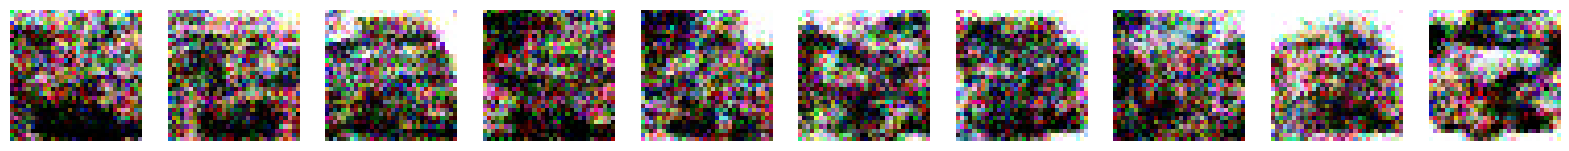


Saved to ./output/example_img_005.png


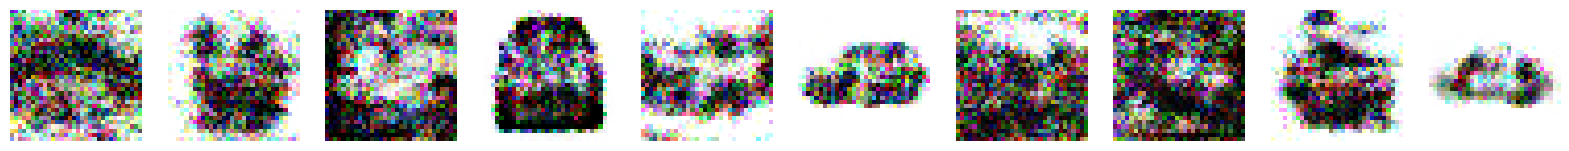

692/692 [==============================] - 901s 1s/step - loss: -0.0028 - reg: 0.0046 - cdiv: -0.0074 - real: 0.0050 - fake: -0.0024
Epoch 7/25
 61/692 [=>............................] - ETA: 13:18 - loss: 0.0018 - reg: 0.0018 - cdiv: -6.0417e-05 - real: -0.0082 - fake: -0.0082

KeyboardInterrupt: 

In [20]:
ebm.fit(
    train,
    shuffle=True,
    epochs=25,
    callbacks=[
        save_model_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

In [21]:
start_imgs = (
    np.random.uniform(size=(10, 32, 32, 3)) * 2 - 1
)

In [ ]:
display(start_imgs)

In [32]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=10000,
    step_size=10,
    noise=0.005,
    return_img_per_step=True,
)

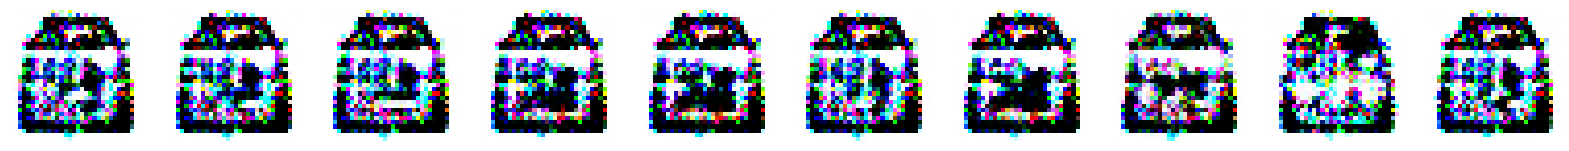

In [33]:
display(gen_img[-1].numpy())

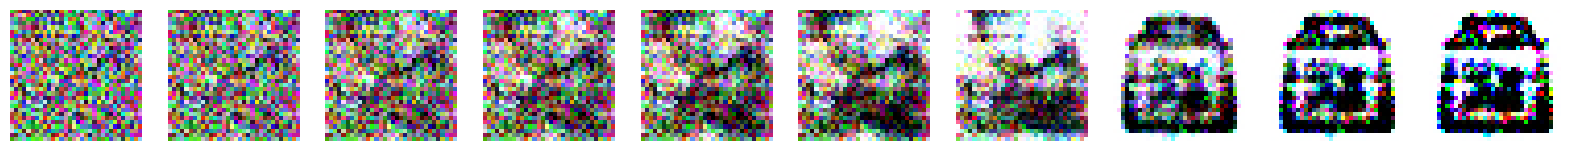

In [34]:
imgs = []
for i in [0, 10, 30, 50, 100, 300, 1000, 3000, 5000, 9999]:
    imgs.append(gen_img[i].numpy()[4])

display(np.array(imgs))

In [42]:
start_imgs = (
    np.random.uniform(size=(10, 32, 32, 3)) * 2 - 1
)

gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=5000,
    step_size=200,
    noise=0.01,
    return_img_per_step=True,
)

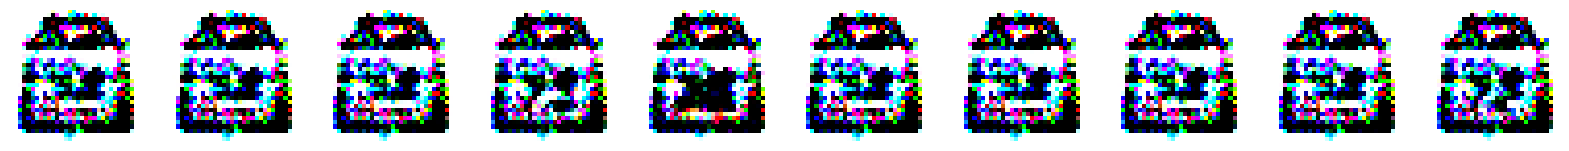

In [43]:
display(gen_img[-1].numpy())

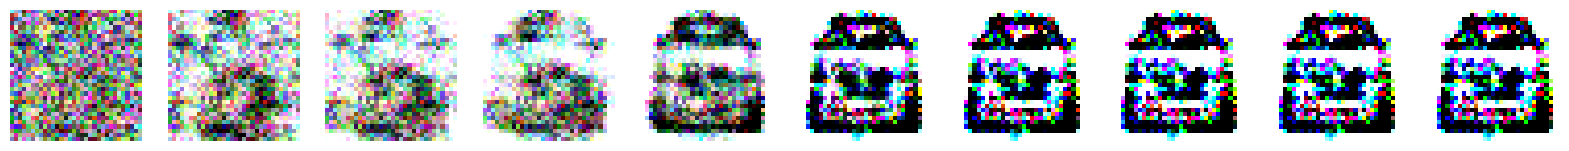

In [44]:
imgs = []
for i in [0, 10, 30, 50, 100, 300, 1000, 3000, 4000, 4999]:
    imgs.append(gen_img[i].numpy()[1])

display(np.array(imgs))